In [1]:
import pandas as pd
import logging
import os

# Configure logging to packet1.txt
logging.basicConfig(filename="packet1.txt", level=logging.INFO, format="%(asctime)s, %(message)s")

# Define packet length threshold
MAX_PACKET_LENGTH = 100  # Change as needed
BLOCKED_IPS_FILE = os.path.abspath("blocked_ips.txt")  # Absolute path for reliability
CSV_FILE_PATH = os.path.abspath("/Users/devvratsolanki/Downloads/Capstone_updated.csv")  # Ensure this is correct

def load_blocked_ips():
    """Load blocked IPs from file."""
    if os.path.exists(BLOCKED_IPS_FILE):
        with open(BLOCKED_IPS_FILE, "r") as f:
            return set(f.read().splitlines())
    return set()

def save_blocked_ip(ip):
    """Save blocked IP to file (ensure file is created)."""
    with open(BLOCKED_IPS_FILE, "a") as f:
        f.write(ip + "\n")

def process_packets(file_path):
    """Process packet data and block IPs with length >= 100."""
    if not os.path.exists(file_path):
        print(f"Error: File '{file_path}' not found. Please check the file path.")
        logging.error(f"File '{file_path}' not found.")
        return

    blocked_ips = load_blocked_ips()
    
    df = pd.read_csv(file_path)
    
    # Print column names for debugging
    print("Column Names in CSV:", df.columns)

    # Ensure required columns exist
    required_columns = {"Time", "Source", "Protocol", "Length"}
    if not required_columns.issubset(df.columns):
        print("Error: CSV file does not contain required columns.")
        return

    blocked_count = 0  # Counter for debugging

    for index, row in df.iterrows():
        timestamp = row["Time"]
        ip = row["Source"]
        protocol = row["Protocol"]
        packet_length = row["Length"]

        try:
            packet_length = float(packet_length)
        except ValueError:
            log_entry = f"{timestamp}, {ip}, Protocol: {protocol}, Length: INVALID (Skipping row {index})"
            logging.info(log_entry)
            continue  # Skip invalid values

        log_entry = f"{timestamp}, {ip}, Protocol: {protocol}, Length: {packet_length}"
        logging.info(log_entry)

        if packet_length >= MAX_PACKET_LENGTH and ip not in blocked_ips:
            blocked_ips.add(ip)
            save_blocked_ip(ip)
            blocked_count += 1

            block_entry = f"{timestamp}, {ip}, Protocol: {protocol}, Length: {packet_length} (BLOCKED)"
            logging.info(block_entry)

    if blocked_count == 0:
        print("No IPs blocked. Check packet length values.")
    else:
        print(f"{blocked_count} IPs blocked and saved to {BLOCKED_IPS_FILE}")

# Run the function on the provided file
process_packets(CSV_FILE_PATH)

Column Names in CSV: Index(['Time', 'Source', 'No.', 'Destination', 'Protocol', 'Length'], dtype='object')
No IPs blocked. Check packet length values.


In [2]:
import subprocess
import platform
import threading

# Define the base IP of the Class C network
base_ip = "192.168.237"

# List to store reachable IPs
reachable_ips = []

# Define the ping function to check each IP
def ping_ip(ip):
    # Determine the correct ping parameter based on the operating system
    param = "-n" if platform.system().lower() == "windows" else "-c"
    
    # Run the ping command and capture the output
    try:
        result = subprocess.run(
            ["ping", param, "1", ip],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE,
            timeout=1  # Set a timeout of 1 second
        )
        
        # Check for "unreachable" in the output (common indication on many systems)
        output = result.stdout.decode('utf-8').lower()
        if "unreachable" not in output and result.returncode == 0:
            reachable_ips.append(ip)
            # print(f"{ip} is reachable")
    
    except subprocess.TimeoutExpired:
        # If the ping command times out, we consider it unreachable
        pass

# Launch threads to ping IPs in parallel
threads = []
for i in range(1, 255):
    ip = f"{base_ip}.{i}"
    thread = threading.Thread(target=ping_ip, args=(ip,))
    threads.append(thread)
    thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

# Print all reachable IPs
print("\nAll reachable IPs:")
for ip in reachable_ips:
    print(ip)


All reachable IPs:


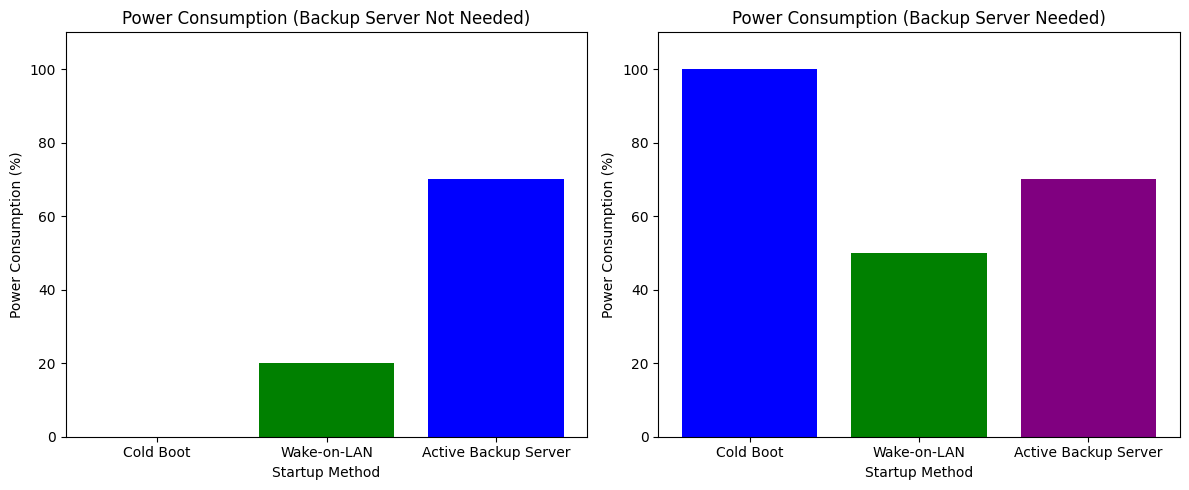

In [3]:
import matplotlib.pyplot as plt

# Define the power consumption data for the two scenarios

# Case 1: When the backup server is not needed (no power consumption for backup server)
labels_no_backup = ['Cold Boot', 'Wake-on-LAN', 'Active Backup Server']
power_consumption_no_backup = [0, 20, 70]  # Power usage for Cold Boot and Wake-on-LAN

# Case 2: When the backup server is needed (backup server consumes some power in standby)
labels_with_backup = ['Cold Boot', 'Wake-on-LAN', 'Active Backup Server']
power_consumption_with_backup = [100, 50, 70]  # Power usage for Cold Boot, Wake-on-LAN, and Backup Server

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for "Backup Server Not Needed"
ax1.bar(labels_no_backup, power_consumption_no_backup, color=['blue', 'green'])
ax1.set_title('Power Consumption (Backup Server Not Needed)')
ax1.set_ylabel('Power Consumption (%)')
ax1.set_xlabel('Startup Method')

# Plot for "Backup Server Needed"
ax2.bar(labels_with_backup, power_consumption_with_backup, color=['blue', 'green', 'purple'])
ax2.set_title('Power Consumption (Backup Server Needed)')
ax2.set_ylabel('Power Consumption (%)')
ax2.set_xlabel('Startup Method')

# Set the same y-axis limit for both plots
max_power_consumption = max(max(power_consumption_no_backup), max(power_consumption_with_backup))
ax1.set_ylim(0, max_power_consumption + 10)
ax2.set_ylim(0, max_power_consumption + 10)

# Show plots
plt.tight_layout()
plt.show()